#  experiment with weightaged 

In [1]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import mysql.connector
import pickle
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam


# Set fixed random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load Data from MySQL
conn = mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="mywork@keshi",
    database="cryptodb"
)
cursor = conn.cursor()

query = """
SELECT timestamp, open, high, low, close, volume 
FROM cryptocurrency_data
WHERE DATE >= '2025-01-23' AND DATE <= '2025-04-1';
"""

cursor.execute(query)
columns = [desc[0] for desc in cursor.description]
bitcoin_df = pd.DataFrame(cursor.fetchall(), columns=columns)
cursor.close()
conn.close()

# Feature Engineering
def process_features(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df['mid_trend_d'] = df['close'].rolling(window=20).mean()
    df['weight_mid_t_d'] = df['close'].ewm(span=20, adjust=False).mean()
    df['market_up_down'] = df['open'] - df['close']
    df['price_fluctuations'] = df['high'] - df['low']
    df['upper_markert_analysis'] = df['high'] - df['open']
    df['down_markert_analysis'] = df['close'] - df['low']
    df['short_trend_d'] = df['close'].rolling(window=14).mean()
    df['short_trend_d_var'] = df['close'].rolling(window=14).std()
    df['close_p_change'] = df['close'].pct_change()
    df['volume_past_direction'] = df['volume'].rolling(window=14).mean()
    df['Volume_Change'] = df['volume'].pct_change()
    df['OPEN_lag1'] = df['open'].shift(1)
    df['CLOSE_lag1'] = df['close'].shift(1)
    df['HIGH_lag1'] = df['high'].shift(1)
    df['LOW_lag1'] = df['low'].shift(1)
    df.dropna(inplace=True)
    return df

bitcoin_df = process_features(bitcoin_df)
bitcoin_df = bitcoin_df.drop(columns=['timestamp'])
bitcoin_df['close_target'] = bitcoin_df['close'].shift(-1)  
bitcoin_df.dropna(inplace=True)

X = bitcoin_df.drop(columns=['close', 'close_target']).values  
y = bitcoin_df['close_target'].values  

# Load Scalers
with open(r"C:\Users\Dell\Desktop\real_e_clg_6\scaled_x_kk.pkl", "rb") as f:
    scaler_x = pickle.load(f)
with open(r"C:\Users\Dell\Desktop\real_e_clg_6\scaled_y_kk.pkl", "rb") as f:
    scaler_y = pickle.load(f)

X_scaled = scaler_x.transform(X)
y_scaled = scaler_y.transform(y.reshape(-1, 1))
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Paths to models
original_model_path = r"C:\Users\Dell\Desktop\real_e_clg_6\btc_biGRU_2.h5"
#original_model_path=r"C:\Users\Dell\Downloads\bitcoin_lstm_best_model_11.keras"
updated_model_path = r"C:\Users\Dell\Desktop\real_e_clg_6\realt_updated_model.h5"

# Load model
if os.path.exists(updated_model_path):
    model = load_model(updated_model_path)
    retraining_on_updated = True
    print("Updated model loaded.")
else:
    model = load_model(original_model_path)
    retraining_on_updated = False
    print("Original model loaded.")



# Retrain the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
X_train_retrain = X_scaled[-30:]
y_train_retrain = y_scaled[-30:]


y_pred_before = model.predict(X_scaled)
rmse_before = np.sqrt(mean_squared_error(y, scaler_y.inverse_transform(y_pred_before)))



print("Retraining the model...")
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
model.fit(X_train_retrain, y_train_retrain, epochs=100, batch_size=4, validation_split=0.1, verbose=1, callbacks=[early_stopping])


y_pred_after = model.predict(X_scaled)
rmse_after = np.sqrt(mean_squared_error(y, scaler_y.inverse_transform(y_pred_after)))

print(f"RMSE Before Retraining: {rmse_before:.2f}")
print(f"RMSE After Retraining: {rmse_after:.2f}")

# Save updated model if RMSE increases by 20%
if rmse_after < rmse_before * 0.8:  # 20% decrease in RMSE
    model.save(updated_model_path)
    print(f"RMSE decreased by at least 20%. Saved new model at {updated_model_path}.")
else:
    print("RMSE did not decrease by 20%. Model not saved.")


# Predict Tomorrow's Close Price using yesterday's input
latest_data = X_scaled[-1].reshape(1, 1, X_scaled.shape[2])  
predicted_scaled = model.predict(latest_data)
predicted_price_updated = scaler_y.inverse_transform(predicted_scaled)[0][0] 

if retraining_on_updated == True:
    original_model = load_model(original_model_path)
    predicted_scaled_original = original_model.predict(latest_data)
    predicted_price_original = scaler_y.inverse_transform(predicted_scaled_original)[0][0]
    
    final_prediction = (0.6 * predicted_price_updated) + (0.4 * predicted_price_original)
else:
    final_prediction = predicted_price_updated

print(f"Final Predicted Close Price for Today: {final_prediction:.2f}")


Original model loaded.
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Retraining the model...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 386ms/step - loss: 0.0333 - val_loss: 0.0013
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0230 - val_loss: 0.0022
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0264 - val_loss: 0.0021
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0340 - val_loss: 0.0027
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0655 - val_loss: 0.0015
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0258 - val_loss: 0.0120
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0485 - val_loss: 0.0065
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0351 - val_loss: 9.3154e-04
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0147 - val_loss: 0.0012
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0221 - val_loss: 0.0038
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0247 - va

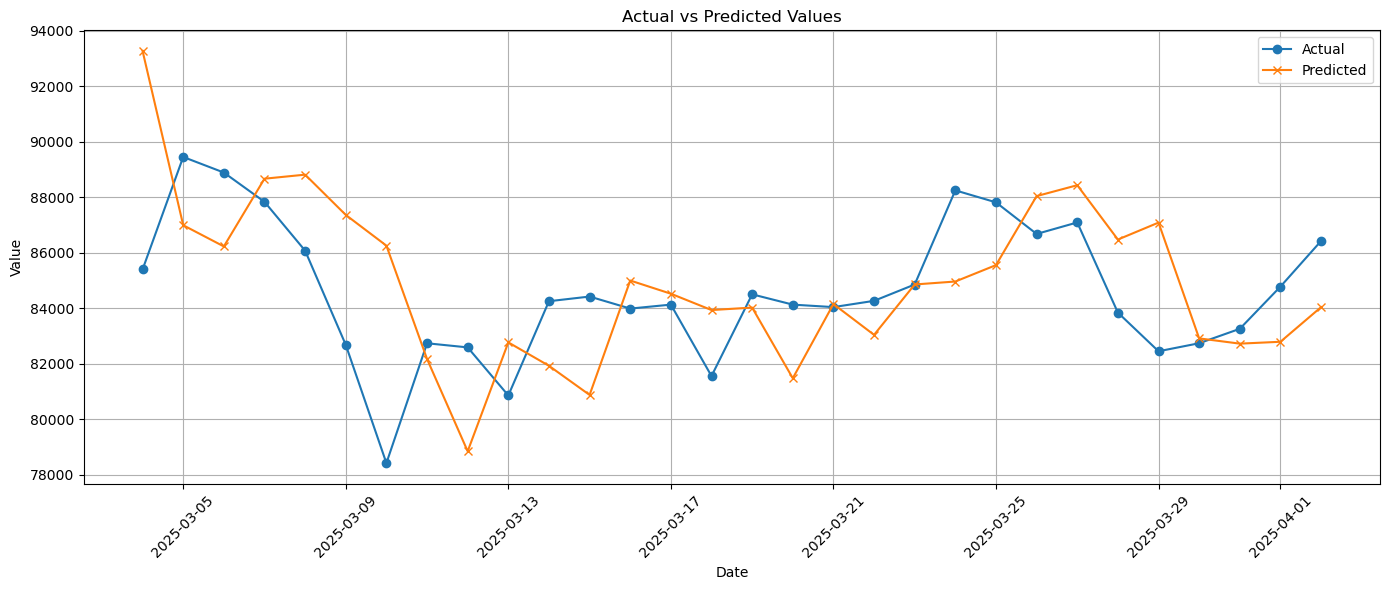

Mean Absolute Error (MAE): 2,333.00
Root Mean Squared Error (RMSE): 3,032.36


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Create DataFrame
data = {
    "Date": [
        "04-03-2025", "05-03-2025", "06-03-2025", "07-03-2025", "08-03-2025", "09-03-2025",
        "10-03-2025", "11-03-2025", "12-03-2025", "13-03-2025", "14-03-2025", "15-03-2025",
        "16-03-2025", "17-03-2025", "18-03-2025", "19-03-2025", "20-03-2025", "21-03-2025",
        "22-03-2025", "23-03-2025", "24-03-2025", "25-03-2025", "26-03-2025", "27-03-2025",
        "28-03-2025", "29-03-2025", "30-03-2025", "31-03-2025", "01-04-2025", "02-04-2025"
    ],
    "Actual": [
        85395.23771, 89447.15853, 88885.77503, 87831.56351, 86072.72551, 82681.52242,
        78422.56801, 82738.15791, 82589.85338, 80857.88256, 84252.76504, 84420.56189,
        83987.22564, 84129.96906, 81557.13429, 84500.76587, 84129.90766, 84040.61486,
        84266.09828, 84854.33332, 88244.72349, 87813.25092, 86675.05995, 87089.32152,
        83842.07353, 82450.46114, 82739.53422, 83258.71288, 84778.7624, 86421.75188
    ],
    "Predicted": [
        93265.2, 86988.93, 86225.48, 88664.66, 88810.12, 87360.19,
        86253.76, 82172.1, 78848.28, 82769.86, 81927.11, 80877.75,
        84997.69, 84522.65, 83934.52, 84023.09, 81479.12, 84150.86,
        83041.15, 84855.66, 84961.98, 85552.69, 88037.99, 88430.04,
        86473.38, 87083.46, 82913.94, 82725.01, 82792.29, 84039.94
    ]
}

df = pd.DataFrame(data)
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

# Step 2: Plot Actual vs Predicted
plt.figure(figsize=(14, 6))
plt.plot(df["Date"], df["Actual"], label="Actual", marker='o')
plt.plot(df["Date"], df["Predicted"], label="Predicted", marker='x')

plt.title("Actual vs Predicted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("actual_vs_predicted.png", dpi=300)
plt.show()

# Step 3: Calculate Metrics
mae = mean_absolute_error(df["Actual"], df["Predicted"])
rmse = np.sqrt(mean_squared_error(df["Actual"], df["Predicted"]))
#r2 = r2_score(df["Actual"], df["Predicted"])

print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
#print(f"R-squared (R² Score): {r2:.4f}")

# Conclusion

#### We evaluated the model's performance on the unseen March 2025 daily data, comparing actual vs predicted Bitcoin prices.

#### Mean Absolute Error (MAE): 2,333.00
Root Mean Squared Error (RMSE): 3,032.36

These error values are reasonable and acceptable, considering:

The model was trained on daily data (not minute/second-level data)
Bitcoin prices are highly volatile, even on a daily basis
Small day-to-day variations are difficult to capture precisely without higher-frequency data
The RMSE reflects that while our model captures the overall trend reasonably well, it may miss some finer short-term fluctuations due to the absence of high-resolution temporal patterns.